In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel, AutoTokenizer, CLIPTextModelWithProjection
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial import distance
import torch
import torch.nn.functional as F

BERT_MODEL = "roberta-base"  # Specify the RoBERTa model
MAX_LENGTH = 128
CLIP_MAX_LENGTH = 77  # Set this to the maximum sequence length supported by CLIP
TEST_SIZE = 0.2
SEED = 42

USE_ATT = True

BERT_DROPOUT = 0.2
LSTM_UNITS = 512
DENSE_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_DROPOUT = 0.2
EPOCHS = 10  # (Default 10)
BATCH_SIZE = 32

def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

random_seed(SEED)

# Load the CLIP model and tokenizer
clipmodel = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
cliptokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

def attention_weighted_average(chunk_embeds):
    # Convert to tensor
    chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
    
    # Linear transformation to get attention scores
    att_weights = torch.nn.Linear(chunk_embeds.size(-1), 1, bias=False)(chunk_embeds)
    att_weights = F.softmax(att_weights, dim=0)
    
    # Compute the weighted average of chunk embeddings
    weighted_avg = torch.sum(att_weights * chunk_embeds, dim=0)
    
    return weighted_avg.detach().numpy()  # Detach from the graph before converting to numpy


def get_clip_embeddings(sentences, cliptokenizer, clipmodel, max_length):
    clip_embeds = []
    for sentence in tqdm(sentences):
        words = sentence.split()
        if len(words) > max_length:
            chunks = [words[i:i + max_length] for i in range(0, len(words), max_length)]
            chunk_embeds = []
            for chunk in chunks:
                chunk_sentence = " ".join(chunk)
                clipinputs = cliptokenizer(chunk_sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
                clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
                clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
                outputs = clipmodel(**clipinputs)
                chunk_embeds.append(outputs.text_embeds.cpu().detach().numpy())
            # Compute weighted average using attention mechanism
            weighted_avg_embed = attention_weighted_average(chunk_embeds)
            clip_embeds.append(weighted_avg_embed)
        else:
            clipinputs = cliptokenizer(sentence, return_tensors="pt", padding="max_length", max_length=max_length, truncation=True)
            clipinputs["input_ids"] = clipinputs["input_ids"].cuda()
            clipinputs["attention_mask"] = clipinputs["attention_mask"].cuda()
            outputs = clipmodel(**clipinputs)
            clip_embeds.append(outputs.text_embeds.cpu().detach().numpy())
    return np.vstack(clip_embeds)


def tokenize(sentences, tokenizer):
    input_ids, input_masks = [], []
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens=True,
                                       max_length=MAX_LENGTH,
                                       padding='max_length',
                                       truncation=True,
                                       return_attention_mask=True,
                                       return_token_type_ids=False)  # Roberta doesn't use token_type_ids
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])

    return (np.asarray(input_ids, dtype='int32'),
            np.asarray(input_masks, dtype='int32'))

# Define base Roberta configs
config = RobertaConfig.from_pretrained(BERT_MODEL,
                                       output_hidden_states=False,
                                       attention_probs_dropout_prob=BERT_DROPOUT,
                                       output_attentions=True)
config.output_hidden_states = False
transformer_model = TFRobertaModel.from_pretrained(BERT_MODEL, config=config)

# Freeze the pre-trained layers for fine-tuning
for layer in transformer_model.layers[:3]:
    layer.trainable = False

# Defining tokenizer
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL,
                                             add_special_tokens=True,
                                             max_length=MAX_LENGTH,
                                             padding='max_length',
                                             truncation=True)


# Load training data
train_data = pd.read_csv("../dataset/i_train.csv")
train_sentences = train_data['sentence'].tolist()
train_intensity = train_data['intensity'].tolist() 

# Load testing data
test_data = pd.read_csv("../dataset/i_test.csv")
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist() 

# Shuffle training data
train_data = list(zip(train_sentences, train_intensity))
random.shuffle(train_data)
train_sentences, train_intensity = zip(*train_data)

# Tokenize the data
train_input_ids, train_input_masks = tokenize(train_sentences, tokenizer)
test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)

# Convert intensity values to numpy arrays
y_tr = np.asarray(train_intensity)
y_te = np.asarray(test_intensity)

# Get CLIP embeddings for train and test sets
# train_clip_embeds = get_clip_embeddings(train_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)
# test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Administrator\anaconda3\envs\research\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequen

  6%|████▊                                                                          | 298/4843 [00:04<01:03, 72.03it/s]C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_6268\3690122242.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  chunk_embeds = torch.tensor(chunk_embeds, dtype=torch.float32)
100%|██████████████████████████████████████████████████████████████████████████████| 4843/4843 [01:09<00:00, 69.89it/s]


152/152 [==============================] - 42s 250ms/step


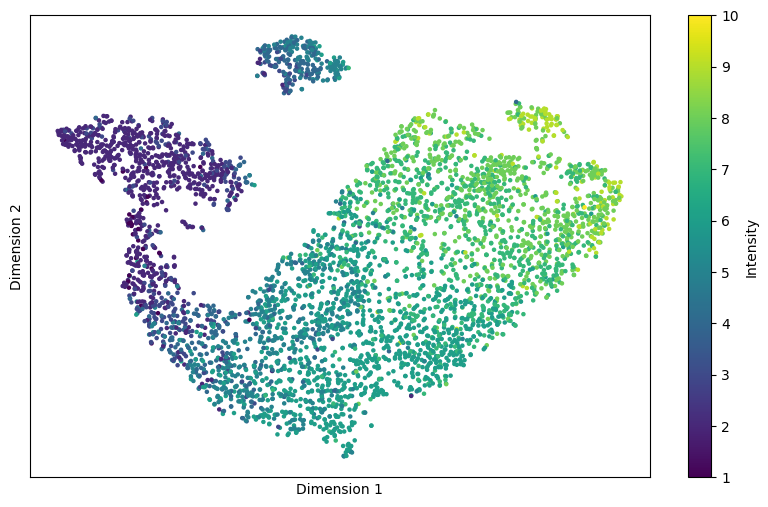

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from sklearn.manifold import TSNE
import transformers
import pandas as pd

custom_objects = {'TFRobertaModel': transformers.TFRobertaModel}

model = load_model('roberta-clip.h5', custom_objects=custom_objects)
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Load the test data
test_data = pd.read_csv("../dataset/i_train.csv") 
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist()


test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)
test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

# Get embeddings from the model
embeddings = embedding_model.predict([test_input_ids, test_input_masks, test_clip_embeds])

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plotting t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=test_intensity, cmap='viridis', s=5)
plt.colorbar(label='Intensity')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Remove x and y tick labels
plt.xticks([])
plt.yticks([])
plt.show()


100%|██████████████████████████████████████████████████████████████████████████████| 6054/6054 [01:21<00:00, 74.01it/s]


190/190 [==============================] - 51s 251ms/step


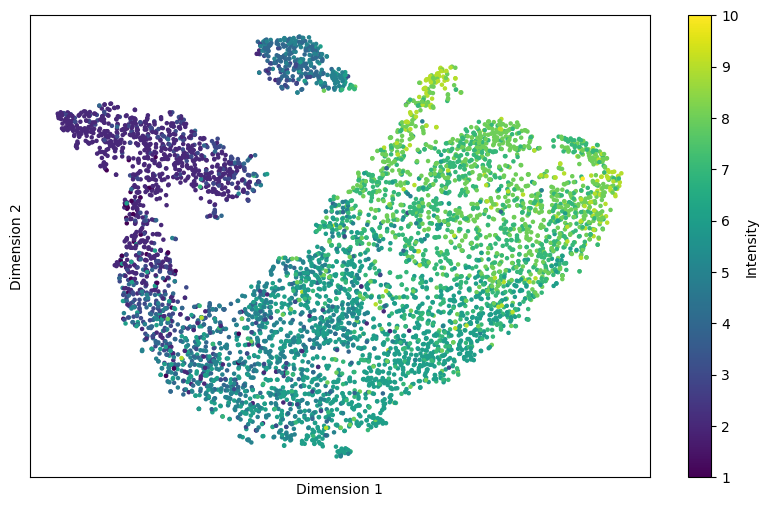

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from sklearn.manifold import TSNE
import transformers
import pandas as pd

custom_objects = {'TFRobertaModel': transformers.TFRobertaModel}

model = load_model('roberta-clip.h5', custom_objects=custom_objects)
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Load the test data
test_data = pd.read_csv("../dataset/train_test.csv") 
test_sentences = test_data['sentence'].tolist()
test_intensity = test_data['intensity'].tolist()


test_input_ids, test_input_masks = tokenize(test_sentences, tokenizer)
test_clip_embeds = get_clip_embeddings(test_sentences, cliptokenizer, clipmodel, CLIP_MAX_LENGTH)

# Get embeddings from the model
embeddings = embedding_model.predict([test_input_ids, test_input_masks, test_clip_embeds])

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

# Plotting t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=test_intensity, cmap='viridis', s=5)
plt.colorbar(label='Intensity')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Remove x and y tick labels
plt.xticks([])
plt.yticks([])
plt.show()
